In [31]:
# %pip install tqdm
# %pip install python-dotenv
# %pip install torch==2.4.0+cu118
# %pip install scikit_learn==1.2.2
# %pip install ipython
# %pip install pandas
# %pip install numpy
# %pip install matplotlib
# %pip install tabulate
# %pip install scipy
# %pip install git+https://github.com/Louis-Li-dev/ML_tool_kit

In [32]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *
from dotenv import load_dotenv
from model.CNN import ConditionalSegmentationVAE
from mkit.torch_support.tensor_utils import xy_to_tensordataset
from torch import nn
from IPython.display import clear_output
from sklearn.ensemble import RandomForestRegressor
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")

In [33]:
import torch
from torch import nn

class ConvolutionalEncoder(nn.Module):
    """
    Convolutional Encoder module with variable number of layers.

    Args:
        basic_dim (int): Base dimension for feature maps.
        n_layers (int): Number of convolutional blocks. The first block goes from 1 channel 
                        to basic_dim * 4 channels, and each subsequent block halves the channels.
    """
    def __init__(self, basic_dim: int, n_layers: int):
        super(ConvolutionalEncoder, self).__init__()
        layers = []
        # First block: from 1 channel to basic_dim * 4 channels.
        in_channels = 1
        out_channels = basic_dim * 4
        layers.append(self.__block(in_channels, out_channels, kernel=(3, 3)))
        in_channels = out_channels
        
        # Subsequent blocks: each block halves the number of channels.
        for _ in range(n_layers - 1):
            out_channels = in_channels // 2
            layers.append(self.__block(in_channels, out_channels, kernel=(3, 3)))
            in_channels = out_channels
        
        self.encoder = nn.Sequential(*layers)
        self.out_channels = in_channels  # Save final channel count for decoder reference

    def __block(self, in_channels: int, out_channels: int, kernel: tuple) -> nn.Sequential:
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride=1, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.encoder(x)

class ConvolutionalDecoder(nn.Module):
    """
    Convolutional Decoder module with variable number of layers.

    Args:
        basic_dim (int): Base dimension for feature maps (should be the same as used in the encoder).
        n_layers (int): Number of deconvolutional blocks. The decoder starts with a channel count that
                        is expected to match the encoder's output, then doubles the channels each block
                        until reconstructing a single-channel image.
    """
    def __init__(self, basic_dim: int, n_layers: int):
        super(ConvolutionalDecoder, self).__init__()
        layers = []
        # The starting number of channels for the decoder should match the encoder's output.
        # In the encoder, after n_layers blocks, the number of channels becomes:
        #   basic_dim * 4 // (2 ** (n_layers - 1))
        in_channels = basic_dim * 4 // (2 ** (n_layers - 1))
        
        # Build (n_layers - 1) deconvolution blocks that double the channels.
        for _ in range(n_layers - 1):
            out_channels = in_channels * 2
            layers.append(self.__block(in_channels, out_channels, kernel=(3, 3)))
            in_channels = out_channels
        
        # Final output layer: produce a 1-channel output image.
        self.out = nn.ConvTranspose2d(in_channels, 1, kernel_size=(3, 3), stride=1, padding=1)
        self.decoder = nn.Sequential(*layers)

    def __block(self, in_channels: int, out_channels: int, kernel: tuple) -> nn.Sequential:
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel, stride=1, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decoder(x)
        return self.out(x)

class AE(nn.Module):
    """
    Convolutional Autoencoder combining the encoder and decoder.

    Args:
        basic_dim (int): Base dimension for feature maps.
        n_layers (int): Number of layers for both the encoder and decoder.
    """
    def __init__(self, basic_dim: int, n_layers: int):
        super(AE, self).__init__()
        self.encoder = ConvolutionalEncoder(basic_dim, n_layers)
        self.decoder = ConvolutionalDecoder(basic_dim, n_layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def generate(basic_dim: int, n_layers: int, output_type: str = "autoencoder", device: str = "cpu") -> nn.Module:
    """
    Generates a model based on the specified output type.

    Args:
        basic_dim (int): Base dimension for feature maps.
        n_layers (int): Number of layers for both encoder and decoder.
        output_type (str): One of 'encoder', 'decoder', or 'autoencoder'.
        device (str): 'cpu' or 'cuda'.

    Returns:
        A PyTorch model on the specified device.
    """
    device = torch.device(device)
    if output_type == "encoder":
        model = ConvolutionalEncoder(basic_dim, n_layers)
    elif output_type == "decoder":
        model = ConvolutionalDecoder(basic_dim, n_layers)
    elif output_type == "autoencoder":
        model = AE(basic_dim, n_layers)
    else:
        raise ValueError("Invalid output_type. Choose from 'encoder', 'decoder', or 'autoencoder'.")
    return model.to(device)


- Dataset

In [34]:
if not os.path.exists(DATA_DIR): raise FileNotFoundError("Make sure the data directory is correctly placed.")

In [35]:
files = get_files(DATA_DIR)

return_list = []
file = files[0]
city_name = file.split('\\')[-1].split('.csv')[0].split('_')[0]

path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']

original dataset size: 238
dataset size with duplicates removed: 172


In [36]:
# for idx, label in enumerate(labels):
#     plt.imshow(labels[idx])
#     plt.savefig(f'../fig/{idx}_{file_name}.png')
#     plt.show()


- x y splitting

In [37]:
from sklearn.model_selection import train_test_split


unique_labels = [u for u in labels if np.array(np.where(u != 0)).T.shape[0] > 1]
padded_labels = []
for label in unique_labels:
    unique_vals = np.unique(label)[1:]

    max_val = label.max()
    new_vals = []
    count = 0
    for val in unique_vals:    
        dummy_vals = np.zeros(label.shape)
        dummy_vals[np.where(label == val)] = 1
        new_vals.append(dummy_vals)
        count += 1
    for i in range(count, MAX_LEN):
        dummy_vals = np.zeros(label.shape)
        new_vals.append(dummy_vals)
    new_vals = np.array(new_vals)
    padded_labels.append(new_vals)
train_labels, test_labels = train_test_split(np.expand_dims(np.array(unique_labels), axis=1), test_size=.2)


In [38]:
np.max(train_labels[0][0])

3.0

- data processing

In [39]:

loader, val_loader = xy_to_tensordataset(
    train_labels, train_labels,
    return_loader=True, 
    batch_size=32,
    input_dtype=torch.float32,
    output_dtype=torch.float32,
    val_ratio=.15,
)

In [40]:
next(iter(loader))[0].shape

torch.Size([32, 1, 48, 64])

In [41]:
from mkit.torch_support.nn_utils import training_loop
model = AE(basic_dim=64, n_layers=2)

training_loop(
    model, 
    train_loader=loader,
    val_loader=val_loader,
    optimizer=torch.optim.Adamax(model.parameters()),
    criterion=nn.L1Loss(),
    device=torch.device('cuda'),
    epochs=1000,
    early_stopping=True,
    patience=15
)

EPOCH 1/1000: 100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Epoch [1/1000] Training Loss: 6.7086  Validation Loss: 1.8483



EPOCH 2/1000: 100%|██████████| 4/4 [00:00<00:00,  9.68it/s]


Epoch [2/1000] Training Loss: 1.3463  Validation Loss: 1.2005



EPOCH 3/1000: 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]


Epoch [3/1000] Training Loss: 0.7951  Validation Loss: 0.5935



EPOCH 4/1000: 100%|██████████| 4/4 [00:00<00:00,  9.56it/s]


Epoch [4/1000] Training Loss: 0.5017  Validation Loss: 0.4582



EPOCH 5/1000: 100%|██████████| 4/4 [00:00<00:00,  9.55it/s]


Epoch [5/1000] Training Loss: 0.3916  Validation Loss: 0.3983



EPOCH 6/1000: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


Epoch [6/1000] Training Loss: 0.3581  Validation Loss: 0.3208



EPOCH 7/1000: 100%|██████████| 4/4 [00:00<00:00,  9.60it/s]


Epoch [7/1000] Training Loss: 0.2732  Validation Loss: 0.3061



EPOCH 8/1000: 100%|██████████| 4/4 [00:00<00:00,  9.83it/s]


Epoch [8/1000] Training Loss: 0.2528  Validation Loss: 0.2639



EPOCH 9/1000: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s]


Epoch [9/1000] Training Loss: 0.2291  Validation Loss: 0.2421



EPOCH 10/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [10/1000] Training Loss: 0.2069  Validation Loss: 0.2280



EPOCH 11/1000: 100%|██████████| 4/4 [00:00<00:00,  9.84it/s]


Epoch [11/1000] Training Loss: 0.1902  Validation Loss: 0.2071



EPOCH 12/1000: 100%|██████████| 4/4 [00:00<00:00,  9.53it/s]


Epoch [12/1000] Training Loss: 0.1731  Validation Loss: 0.1932



EPOCH 13/1000: 100%|██████████| 4/4 [00:00<00:00,  9.61it/s]


Epoch [13/1000] Training Loss: 0.1608  Validation Loss: 0.1804



EPOCH 14/1000: 100%|██████████| 4/4 [00:00<00:00,  9.68it/s]


Epoch [14/1000] Training Loss: 0.1494  Validation Loss: 0.1683



EPOCH 15/1000: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s]


Epoch [15/1000] Training Loss: 0.1378  Validation Loss: 0.1574



EPOCH 16/1000: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch [16/1000] Training Loss: 0.1305  Validation Loss: 0.1508



EPOCH 17/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [17/1000] Training Loss: 0.1260  Validation Loss: 0.1438



EPOCH 18/1000: 100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


Epoch [18/1000] Training Loss: 0.1153  Validation Loss: 0.1368



EPOCH 19/1000: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


Epoch [19/1000] Training Loss: 0.1154  Validation Loss: 0.1317



EPOCH 20/1000: 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]


Epoch [20/1000] Training Loss: 0.1077  Validation Loss: 0.1261



EPOCH 21/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [21/1000] Training Loss: 0.1036  Validation Loss: 0.1224



EPOCH 22/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [22/1000] Training Loss: 0.1015  Validation Loss: 0.1192



EPOCH 23/1000: 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch [23/1000] Training Loss: 0.0966  Validation Loss: 0.1191



EPOCH 24/1000: 100%|██████████| 4/4 [00:00<00:00,  9.91it/s]


Epoch [24/1000] Training Loss: 0.0993  Validation Loss: 0.1172



EPOCH 25/1000: 100%|██████████| 4/4 [00:00<00:00,  9.89it/s]


Epoch [25/1000] Training Loss: 0.0976  Validation Loss: 0.1118



EPOCH 26/1000: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch [26/1000] Training Loss: 0.0938  Validation Loss: 0.1074



EPOCH 27/1000: 100%|██████████| 4/4 [00:00<00:00,  9.79it/s]


Epoch [27/1000] Training Loss: 0.0900  Validation Loss: 0.1074



EPOCH 28/1000: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch [28/1000] Training Loss: 0.0865  Validation Loss: 0.1026



EPOCH 29/1000: 100%|██████████| 4/4 [00:00<00:00,  9.70it/s]


Epoch [29/1000] Training Loss: 0.0860  Validation Loss: 0.1026



EPOCH 30/1000: 100%|██████████| 4/4 [00:00<00:00,  9.77it/s]


Epoch [30/1000] Training Loss: 0.0830  Validation Loss: 0.1009



EPOCH 31/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [31/1000] Training Loss: 0.0815  Validation Loss: 0.0971



EPOCH 32/1000: 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]


Epoch [32/1000] Training Loss: 0.0787  Validation Loss: 0.0953



EPOCH 33/1000: 100%|██████████| 4/4 [00:00<00:00,  9.56it/s]


Epoch [33/1000] Training Loss: 0.0768  Validation Loss: 0.0941



EPOCH 34/1000: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


Epoch [34/1000] Training Loss: 0.0740  Validation Loss: 0.0920



EPOCH 35/1000: 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


Epoch [35/1000] Training Loss: 0.0729  Validation Loss: 0.0905



EPOCH 36/1000: 100%|██████████| 4/4 [00:00<00:00,  9.57it/s]


Epoch [36/1000] Training Loss: 0.0736  Validation Loss: 0.0868



EPOCH 37/1000: 100%|██████████| 4/4 [00:00<00:00,  9.62it/s]


Epoch [37/1000] Training Loss: 0.0702  Validation Loss: 0.0874



EPOCH 38/1000: 100%|██████████| 4/4 [00:00<00:00,  9.61it/s]


Epoch [38/1000] Training Loss: 0.0695  Validation Loss: 0.0844



EPOCH 39/1000: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch [39/1000] Training Loss: 0.0675  Validation Loss: 0.0836



EPOCH 40/1000: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [40/1000] Training Loss: 0.0658  Validation Loss: 0.0813



EPOCH 41/1000: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [41/1000] Training Loss: 0.0638  Validation Loss: 0.0799



EPOCH 42/1000: 100%|██████████| 4/4 [00:00<00:00,  8.89it/s]


Epoch [42/1000] Training Loss: 0.0632  Validation Loss: 0.0794



EPOCH 43/1000: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch [43/1000] Training Loss: 0.0651  Validation Loss: 0.0786



EPOCH 44/1000: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


Epoch [44/1000] Training Loss: 0.0609  Validation Loss: 0.0808



EPOCH 45/1000: 100%|██████████| 4/4 [00:00<00:00,  9.79it/s]


Epoch [45/1000] Training Loss: 0.0613  Validation Loss: 0.0745



EPOCH 46/1000: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s]


Epoch [46/1000] Training Loss: 0.0577  Validation Loss: 0.0805



EPOCH 47/1000: 100%|██████████| 4/4 [00:00<00:00,  9.83it/s]


Epoch [47/1000] Training Loss: 0.0625  Validation Loss: 0.0738



EPOCH 48/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [48/1000] Training Loss: 0.0566  Validation Loss: 0.0735



EPOCH 49/1000: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


Epoch [49/1000] Training Loss: 0.0574  Validation Loss: 0.0807



EPOCH 50/1000: 100%|██████████| 4/4 [00:00<00:00,  9.77it/s]


Epoch [50/1000] Training Loss: 0.0612  Validation Loss: 0.0721



EPOCH 51/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [51/1000] Training Loss: 0.0561  Validation Loss: 0.0685



EPOCH 52/1000: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [52/1000] Training Loss: 0.0548  Validation Loss: 0.0690



EPOCH 53/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [53/1000] Training Loss: 0.0538  Validation Loss: 0.0680



EPOCH 54/1000: 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]


Epoch [54/1000] Training Loss: 0.0546  Validation Loss: 0.0662



EPOCH 55/1000: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [55/1000] Training Loss: 0.0522  Validation Loss: 0.0656



EPOCH 56/1000: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch [56/1000] Training Loss: 0.0514  Validation Loss: 0.0644



EPOCH 57/1000: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [57/1000] Training Loss: 0.0516  Validation Loss: 0.0668



EPOCH 58/1000: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [58/1000] Training Loss: 0.0509  Validation Loss: 0.0629



EPOCH 59/1000: 100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch [59/1000] Training Loss: 0.0498  Validation Loss: 0.0630



EPOCH 60/1000: 100%|██████████| 4/4 [00:00<00:00,  9.56it/s]


Epoch [60/1000] Training Loss: 0.0493  Validation Loss: 0.0621



EPOCH 61/1000: 100%|██████████| 4/4 [00:00<00:00,  9.15it/s]


Epoch [61/1000] Training Loss: 0.0483  Validation Loss: 0.0617



EPOCH 62/1000: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


Epoch [62/1000] Training Loss: 0.0476  Validation Loss: 0.0647



EPOCH 63/1000: 100%|██████████| 4/4 [00:00<00:00,  9.91it/s]


Epoch [63/1000] Training Loss: 0.0483  Validation Loss: 0.0586



EPOCH 64/1000: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch [64/1000] Training Loss: 0.0460  Validation Loss: 0.0582



EPOCH 65/1000: 100%|██████████| 4/4 [00:00<00:00,  9.66it/s]


Epoch [65/1000] Training Loss: 0.0461  Validation Loss: 0.0580



EPOCH 66/1000: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch [66/1000] Training Loss: 0.0445  Validation Loss: 0.0577



EPOCH 67/1000: 100%|██████████| 4/4 [00:00<00:00,  9.76it/s]


Epoch [67/1000] Training Loss: 0.0446  Validation Loss: 0.0605



EPOCH 68/1000: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


Epoch [68/1000] Training Loss: 0.0457  Validation Loss: 0.0558



EPOCH 69/1000: 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]


Epoch [69/1000] Training Loss: 0.0453  Validation Loss: 0.0576



EPOCH 70/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [70/1000] Training Loss: 0.0443  Validation Loss: 0.0570



EPOCH 71/1000: 100%|██████████| 4/4 [00:00<00:00,  9.74it/s]


Epoch [71/1000] Training Loss: 0.0429  Validation Loss: 0.0554



EPOCH 72/1000: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch [72/1000] Training Loss: 0.0430  Validation Loss: 0.0540



EPOCH 73/1000: 100%|██████████| 4/4 [00:00<00:00,  9.80it/s]


Epoch [73/1000] Training Loss: 0.0433  Validation Loss: 0.0529



EPOCH 74/1000: 100%|██████████| 4/4 [00:00<00:00,  9.75it/s]


Epoch [74/1000] Training Loss: 0.0410  Validation Loss: 0.0604



EPOCH 75/1000: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [75/1000] Training Loss: 0.0451  Validation Loss: 0.0562



EPOCH 76/1000: 100%|██████████| 4/4 [00:00<00:00,  9.79it/s]


Epoch [76/1000] Training Loss: 0.0450  Validation Loss: 0.0565



EPOCH 77/1000: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [77/1000] Training Loss: 0.0454  Validation Loss: 0.0535



EPOCH 78/1000: 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


Epoch [78/1000] Training Loss: 0.0459  Validation Loss: 0.0591



EPOCH 79/1000: 100%|██████████| 4/4 [00:00<00:00,  9.65it/s]


Epoch [79/1000] Training Loss: 0.0476  Validation Loss: 0.0586



EPOCH 80/1000: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


Epoch [80/1000] Training Loss: 0.0437  Validation Loss: 0.0530



EPOCH 81/1000: 100%|██████████| 4/4 [00:00<00:00,  9.34it/s]


Epoch [81/1000] Training Loss: 0.0408  Validation Loss: 0.0579



EPOCH 82/1000: 100%|██████████| 4/4 [00:00<00:00, 10.08it/s]


Epoch [82/1000] Training Loss: 0.0446  Validation Loss: 0.0487



EPOCH 83/1000: 100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Epoch [83/1000] Training Loss: 0.0409  Validation Loss: 0.0516



EPOCH 84/1000: 100%|██████████| 4/4 [00:00<00:00,  9.97it/s]


Epoch [84/1000] Training Loss: 0.0394  Validation Loss: 0.0514



EPOCH 85/1000: 100%|██████████| 4/4 [00:00<00:00, 10.22it/s]


Epoch [85/1000] Training Loss: 0.0396  Validation Loss: 0.0534



EPOCH 86/1000: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch [86/1000] Training Loss: 0.0440  Validation Loss: 0.0538



EPOCH 87/1000: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch [87/1000] Training Loss: 0.0474  Validation Loss: 0.0511



EPOCH 88/1000: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch [88/1000] Training Loss: 0.0431  Validation Loss: 0.0493



EPOCH 89/1000: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch [89/1000] Training Loss: 0.0403  Validation Loss: 0.0473



EPOCH 90/1000: 100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Epoch [90/1000] Training Loss: 0.0360  Validation Loss: 0.0462



EPOCH 91/1000: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch [91/1000] Training Loss: 0.0342  Validation Loss: 0.0537



EPOCH 92/1000: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Epoch [92/1000] Training Loss: 0.0385  Validation Loss: 0.0506



EPOCH 93/1000: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch [93/1000] Training Loss: 0.0384  Validation Loss: 0.0487



EPOCH 94/1000: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch [94/1000] Training Loss: 0.0420  Validation Loss: 0.0449



EPOCH 95/1000: 100%|██████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch [95/1000] Training Loss: 0.0366  Validation Loss: 0.0458



EPOCH 96/1000: 100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Epoch [96/1000] Training Loss: 0.0415  Validation Loss: 0.0607



EPOCH 97/1000: 100%|██████████| 4/4 [00:00<00:00, 10.28it/s]


Epoch [97/1000] Training Loss: 0.0437  Validation Loss: 0.0576



EPOCH 98/1000: 100%|██████████| 4/4 [00:00<00:00, 10.12it/s]


Epoch [98/1000] Training Loss: 0.0407  Validation Loss: 0.0573



EPOCH 99/1000: 100%|██████████| 4/4 [00:00<00:00,  9.93it/s]


Epoch [99/1000] Training Loss: 0.0417  Validation Loss: 0.0429



EPOCH 100/1000: 100%|██████████| 4/4 [00:00<00:00,  9.43it/s]


Epoch [100/1000] Training Loss: 0.0391  Validation Loss: 0.0515



EPOCH 101/1000: 100%|██████████| 4/4 [00:00<00:00, 10.13it/s]


Epoch [101/1000] Training Loss: 0.0433  Validation Loss: 0.0442



EPOCH 102/1000: 100%|██████████| 4/4 [00:00<00:00, 10.26it/s]


Epoch [102/1000] Training Loss: 0.0397  Validation Loss: 0.0468



EPOCH 103/1000: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch [103/1000] Training Loss: 0.0366  Validation Loss: 0.0423



EPOCH 104/1000: 100%|██████████| 4/4 [00:00<00:00,  9.91it/s]


Epoch [104/1000] Training Loss: 0.0374  Validation Loss: 0.0474



EPOCH 105/1000: 100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch [105/1000] Training Loss: 0.0376  Validation Loss: 0.0437



EPOCH 106/1000: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


Epoch [106/1000] Training Loss: 0.0385  Validation Loss: 0.0461



EPOCH 107/1000: 100%|██████████| 4/4 [00:00<00:00, 10.16it/s]


Epoch [107/1000] Training Loss: 0.0351  Validation Loss: 0.0406



EPOCH 108/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [108/1000] Training Loss: 0.0344  Validation Loss: 0.0404



EPOCH 109/1000: 100%|██████████| 4/4 [00:00<00:00,  9.69it/s]


Epoch [109/1000] Training Loss: 0.0327  Validation Loss: 0.0421



EPOCH 110/1000: 100%|██████████| 4/4 [00:00<00:00, 10.01it/s]


Epoch [110/1000] Training Loss: 0.0361  Validation Loss: 0.0426



EPOCH 111/1000: 100%|██████████| 4/4 [00:00<00:00, 10.12it/s]


Epoch [111/1000] Training Loss: 0.0398  Validation Loss: 0.0477



EPOCH 112/1000: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [112/1000] Training Loss: 0.0410  Validation Loss: 0.0532



EPOCH 113/1000: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


Epoch [113/1000] Training Loss: 0.0441  Validation Loss: 0.0512



EPOCH 114/1000: 100%|██████████| 4/4 [00:00<00:00, 10.14it/s]


Epoch [114/1000] Training Loss: 0.0408  Validation Loss: 0.0497



EPOCH 115/1000: 100%|██████████| 4/4 [00:00<00:00, 10.20it/s]


Epoch [115/1000] Training Loss: 0.0379  Validation Loss: 0.0511



EPOCH 116/1000: 100%|██████████| 4/4 [00:00<00:00, 10.18it/s]


Epoch [116/1000] Training Loss: 0.0392  Validation Loss: 0.0447



EPOCH 117/1000: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch [117/1000] Training Loss: 0.0361  Validation Loss: 0.0449



EPOCH 118/1000: 100%|██████████| 4/4 [00:00<00:00, 10.02it/s]


Epoch [118/1000] Training Loss: 0.0350  Validation Loss: 0.0419



EPOCH 119/1000: 100%|██████████| 4/4 [00:00<00:00, 10.15it/s]


Epoch [119/1000] Training Loss: 0.0346  Validation Loss: 0.0412



EPOCH 120/1000: 100%|██████████| 4/4 [00:00<00:00, 10.15it/s]


Epoch [120/1000] Training Loss: 0.0320  Validation Loss: 0.0389



EPOCH 121/1000: 100%|██████████| 4/4 [00:00<00:00, 10.28it/s]


Epoch [121/1000] Training Loss: 0.0323  Validation Loss: 0.0494



EPOCH 122/1000: 100%|██████████| 4/4 [00:00<00:00,  9.64it/s]


Epoch [122/1000] Training Loss: 0.0367  Validation Loss: 0.0501



EPOCH 123/1000: 100%|██████████| 4/4 [00:00<00:00,  9.78it/s]


Epoch [123/1000] Training Loss: 0.0357  Validation Loss: 0.0467



EPOCH 124/1000: 100%|██████████| 4/4 [00:00<00:00,  9.66it/s]


Epoch [124/1000] Training Loss: 0.0398  Validation Loss: 0.0468



EPOCH 125/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [125/1000] Training Loss: 0.0399  Validation Loss: 0.0527



EPOCH 126/1000: 100%|██████████| 4/4 [00:00<00:00, 10.22it/s]


Epoch [126/1000] Training Loss: 0.0388  Validation Loss: 0.0430



EPOCH 127/1000: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


Epoch [127/1000] Training Loss: 0.0368  Validation Loss: 0.0468



EPOCH 128/1000: 100%|██████████| 4/4 [00:00<00:00, 10.01it/s]


Epoch [128/1000] Training Loss: 0.0361  Validation Loss: 0.0472



EPOCH 129/1000: 100%|██████████| 4/4 [00:00<00:00,  9.62it/s]


Epoch [129/1000] Training Loss: 0.0355  Validation Loss: 0.0476



EPOCH 130/1000: 100%|██████████| 4/4 [00:00<00:00,  9.77it/s]


Epoch [130/1000] Training Loss: 0.0386  Validation Loss: 0.0433



EPOCH 131/1000: 100%|██████████| 4/4 [00:00<00:00, 10.15it/s]


Epoch [131/1000] Training Loss: 0.0365  Validation Loss: 0.0410



EPOCH 132/1000: 100%|██████████| 4/4 [00:00<00:00, 10.20it/s]


Epoch [132/1000] Training Loss: 0.0333  Validation Loss: 0.0386



EPOCH 133/1000: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch [133/1000] Training Loss: 0.0300  Validation Loss: 0.0548



EPOCH 134/1000: 100%|██████████| 4/4 [00:00<00:00, 10.20it/s]


Epoch [134/1000] Training Loss: 0.0399  Validation Loss: 0.0475



EPOCH 135/1000: 100%|██████████| 4/4 [00:00<00:00, 10.06it/s]


Epoch [135/1000] Training Loss: 0.0358  Validation Loss: 0.0476



EPOCH 136/1000: 100%|██████████| 4/4 [00:00<00:00,  9.67it/s]


Epoch [136/1000] Training Loss: 0.0327  Validation Loss: 0.0442



EPOCH 137/1000: 100%|██████████| 4/4 [00:00<00:00,  9.63it/s]


Epoch [137/1000] Training Loss: 0.0350  Validation Loss: 0.0496



EPOCH 138/1000: 100%|██████████| 4/4 [00:00<00:00,  9.71it/s]


Epoch [138/1000] Training Loss: 0.0355  Validation Loss: 0.0509



EPOCH 139/1000: 100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch [139/1000] Training Loss: 0.0400  Validation Loss: 0.0529



EPOCH 140/1000: 100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Epoch [140/1000] Training Loss: 0.0375  Validation Loss: 0.0434



EPOCH 141/1000: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s]


Epoch [141/1000] Training Loss: 0.0327  Validation Loss: 0.0475



EPOCH 142/1000: 100%|██████████| 4/4 [00:00<00:00, 10.26it/s]


Epoch [142/1000] Training Loss: 0.0380  Validation Loss: 0.0460



EPOCH 143/1000: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch [143/1000] Training Loss: 0.0350  Validation Loss: 0.0516



EPOCH 144/1000: 100%|██████████| 4/4 [00:00<00:00,  9.66it/s]


Epoch [144/1000] Training Loss: 0.0352  Validation Loss: 0.0457



EPOCH 145/1000: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Epoch [145/1000] Training Loss: 0.0374  Validation Loss: 0.0597



EPOCH 146/1000: 100%|██████████| 4/4 [00:00<00:00, 10.27it/s]


Epoch [146/1000] Training Loss: 0.0467  Validation Loss: 0.0369



EPOCH 147/1000: 100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch [147/1000] Training Loss: 0.0347  Validation Loss: 0.0390



EPOCH 148/1000: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Epoch [148/1000] Training Loss: 0.0307  Validation Loss: 0.0345



EPOCH 149/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [149/1000] Training Loss: 0.0290  Validation Loss: 0.0349



EPOCH 150/1000: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [150/1000] Training Loss: 0.0312  Validation Loss: 0.0420



EPOCH 151/1000: 100%|██████████| 4/4 [00:00<00:00, 10.21it/s]


Epoch [151/1000] Training Loss: 0.0337  Validation Loss: 0.0522



EPOCH 152/1000: 100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch [152/1000] Training Loss: 0.0390  Validation Loss: 0.0369



EPOCH 153/1000: 100%|██████████| 4/4 [00:00<00:00, 10.24it/s]


Epoch [153/1000] Training Loss: 0.0314  Validation Loss: 0.0390



EPOCH 154/1000: 100%|██████████| 4/4 [00:00<00:00, 10.07it/s]


Epoch [154/1000] Training Loss: 0.0330  Validation Loss: 0.0540



EPOCH 155/1000: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch [155/1000] Training Loss: 0.0375  Validation Loss: 0.0378



EPOCH 156/1000: 100%|██████████| 4/4 [00:00<00:00,  9.84it/s]


Epoch [156/1000] Training Loss: 0.0316  Validation Loss: 0.0383



EPOCH 157/1000: 100%|██████████| 4/4 [00:00<00:00, 10.17it/s]


Epoch [157/1000] Training Loss: 0.0287  Validation Loss: 0.0425



EPOCH 158/1000: 100%|██████████| 4/4 [00:00<00:00,  9.59it/s]


Epoch [158/1000] Training Loss: 0.0309  Validation Loss: 0.0399



EPOCH 159/1000: 100%|██████████| 4/4 [00:00<00:00,  9.90it/s]


Epoch [159/1000] Training Loss: 0.0312  Validation Loss: 0.0364



EPOCH 160/1000: 100%|██████████| 4/4 [00:00<00:00,  9.82it/s]


Epoch [160/1000] Training Loss: 0.0294  Validation Loss: 0.0342



EPOCH 161/1000: 100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch [161/1000] Training Loss: 0.0281  Validation Loss: 0.0322



EPOCH 162/1000: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch [162/1000] Training Loss: 0.0278  Validation Loss: 0.0338



EPOCH 163/1000: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s]


Epoch [163/1000] Training Loss: 0.0293  Validation Loss: 0.0335



EPOCH 164/1000: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s]


Epoch [164/1000] Training Loss: 0.0309  Validation Loss: 0.0397



EPOCH 165/1000: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch [165/1000] Training Loss: 0.0293  Validation Loss: 0.0374



EPOCH 166/1000: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch [166/1000] Training Loss: 0.0339  Validation Loss: 0.0416



EPOCH 167/1000: 100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch [167/1000] Training Loss: 0.0359  Validation Loss: 0.0495



EPOCH 168/1000: 100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Epoch [168/1000] Training Loss: 0.0360  Validation Loss: 0.0320



EPOCH 169/1000: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Epoch [169/1000] Training Loss: 0.0383  Validation Loss: 0.0570



EPOCH 170/1000: 100%|██████████| 4/4 [00:00<00:00,  9.94it/s]


Epoch [170/1000] Training Loss: 0.0371  Validation Loss: 0.0616



EPOCH 171/1000: 100%|██████████| 4/4 [00:00<00:00,  9.79it/s]


Epoch [171/1000] Training Loss: 0.0457  Validation Loss: 0.0426



EPOCH 172/1000: 100%|██████████| 4/4 [00:00<00:00,  9.72it/s]


Epoch [172/1000] Training Loss: 0.0352  Validation Loss: 0.0360



EPOCH 173/1000: 100%|██████████| 4/4 [00:00<00:00,  9.89it/s]


Epoch [173/1000] Training Loss: 0.0284  Validation Loss: 0.0453



EPOCH 174/1000: 100%|██████████| 4/4 [00:00<00:00,  9.89it/s]


Epoch [174/1000] Training Loss: 0.0373  Validation Loss: 0.0372



EPOCH 175/1000: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


Epoch [175/1000] Training Loss: 0.0385  Validation Loss: 0.0326



EPOCH 176/1000: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s]


Epoch [176/1000] Training Loss: 0.0314  Validation Loss: 0.0445



EPOCH 177/1000: 100%|██████████| 4/4 [00:00<00:00, 10.30it/s]


Epoch [177/1000] Training Loss: 0.0371  Validation Loss: 0.0321



EPOCH 178/1000: 100%|██████████| 4/4 [00:00<00:00, 10.32it/s]


Epoch [178/1000] Training Loss: 0.0298  Validation Loss: 0.0384



EPOCH 179/1000: 100%|██████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch [179/1000] Training Loss: 0.0301  Validation Loss: 0.0405



EPOCH 180/1000: 100%|██████████| 4/4 [00:00<00:00, 10.33it/s]


Epoch [180/1000] Training Loss: 0.0274  Validation Loss: 0.0355



EPOCH 181/1000: 100%|██████████| 4/4 [00:00<00:00, 10.34it/s]


Epoch [181/1000] Training Loss: 0.0269  Validation Loss: 0.0336



EPOCH 182/1000: 100%|██████████| 4/4 [00:00<00:00, 10.31it/s]


Epoch [182/1000] Training Loss: 0.0264  Validation Loss: 0.0448



EPOCH 183/1000: 100%|██████████| 4/4 [00:00<00:00, 10.28it/s]


Epoch [183/1000] Training Loss: 0.0327  Validation Loss: 0.0301



EPOCH 184/1000: 100%|██████████| 4/4 [00:00<00:00,  9.88it/s]


Epoch [184/1000] Training Loss: 0.0282  Validation Loss: 0.0375



EPOCH 185/1000: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]


Epoch [185/1000] Training Loss: 0.0277  Validation Loss: 0.0316



EPOCH 186/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [186/1000] Training Loss: 0.0241  Validation Loss: 0.0263



EPOCH 187/1000: 100%|██████████| 4/4 [00:00<00:00, 10.14it/s]


Epoch [187/1000] Training Loss: 0.0245  Validation Loss: 0.0384



EPOCH 188/1000: 100%|██████████| 4/4 [00:00<00:00, 10.19it/s]


Epoch [188/1000] Training Loss: 0.0312  Validation Loss: 0.0320



EPOCH 189/1000: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


Epoch [189/1000] Training Loss: 0.0295  Validation Loss: 0.0305



EPOCH 190/1000: 100%|██████████| 4/4 [00:00<00:00, 10.14it/s]


Epoch [190/1000] Training Loss: 0.0285  Validation Loss: 0.0298



EPOCH 191/1000: 100%|██████████| 4/4 [00:00<00:00,  9.95it/s]


Epoch [191/1000] Training Loss: 0.0303  Validation Loss: 0.0285



EPOCH 192/1000: 100%|██████████| 4/4 [00:00<00:00,  9.73it/s]


Epoch [192/1000] Training Loss: 0.0351  Validation Loss: 0.0334



EPOCH 193/1000: 100%|██████████| 4/4 [00:00<00:00,  9.81it/s]


Epoch [193/1000] Training Loss: 0.0333  Validation Loss: 0.0372



EPOCH 194/1000: 100%|██████████| 4/4 [00:00<00:00, 10.25it/s]


Epoch [194/1000] Training Loss: 0.0341  Validation Loss: 0.0401



EPOCH 195/1000: 100%|██████████| 4/4 [00:00<00:00, 10.29it/s]


Epoch [195/1000] Training Loss: 0.0340  Validation Loss: 0.0331



EPOCH 196/1000: 100%|██████████| 4/4 [00:00<00:00, 10.13it/s]


Epoch [196/1000] Training Loss: 0.0352  Validation Loss: 0.0372



EPOCH 197/1000: 100%|██████████| 4/4 [00:00<00:00, 10.10it/s]


Epoch [197/1000] Training Loss: 0.0349  Validation Loss: 0.0334



EPOCH 198/1000: 100%|██████████| 4/4 [00:00<00:00, 10.21it/s]


Epoch [198/1000] Training Loss: 0.0361  Validation Loss: 0.0346



EPOCH 199/1000: 100%|██████████| 4/4 [00:00<00:00, 10.23it/s]


Epoch [199/1000] Training Loss: 0.0288  Validation Loss: 0.0326



EPOCH 200/1000: 100%|██████████| 4/4 [00:00<00:00,  9.85it/s]


Epoch [200/1000] Training Loss: 0.0250  Validation Loss: 0.0359



EPOCH 201/1000: 100%|██████████| 4/4 [00:00<00:00,  9.97it/s]


Epoch [201/1000] Training Loss: 0.0287  Validation Loss: 0.0289



EPOCH 202/1000: 100%|██████████| 4/4 [00:00<00:00,  9.99it/s]

Epoch [202/1000] Training Loss: 0.0302  Validation Loss: 0.0434

Training stopped after 16 consecutive iterations without improvement.
Training completed.
Best validation loss: 0.026274217292666435, model loaded with the selected parameters


AE(
  (encoder): ConvolutionalEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
      (1): Sequential(
        (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
  )
  (decoder): ConvolutionalDecoder(
    (out): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
 

In [42]:
pred = model(torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda')))


In [43]:
import os
import matplotlib.pyplot as plt
for idx in range(len(test_labels)):
    for count, (pred_img, label_img) in enumerate(zip(pred[idx].cpu().detach(), test_labels[idx])):
        # Create a figure with 1 row and 2 columns, and set an appropriate figure size
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        # Plot prediction image with a title and a shrunken colorbar with some padding
        pred_img[pred_img < 1] = 0
        im0 = axes[0].imshow(pred_img, cmap='viridis')
        axes[0].set_title("Prediction")
        fig.colorbar(im0, ax=axes[0], shrink=0.7, pad=0.05)
        
        # Plot ground truth image with a title and a shrunken colorbar with some padding
        im1 = axes[1].imshow(label_img, cmap='viridis')
        axes[1].set_title("Ground Truth")
        fig.colorbar(im1, ax=axes[1], shrink=0.7, pad=0.05)
        
        # Adjust layout to leave space for the suptitle
        fig.subplots_adjust(top=0.85)
        NAME = f"Autoencoder_{count}_OM"
        fig.suptitle(NAME, fontsize=16)
        
        # Create output directory if it doesn't exist
        PATH = f'../fig/OM/{idx}'
        os.makedirs(PATH, exist_ok=True)
        
        # Save and close the figure
        plt.savefig(f"{PATH}/{NAME}.png")
        plt.close(fig)


In [44]:
np.std(latent.reshape(latent.shape[0], -1))

0.72179097

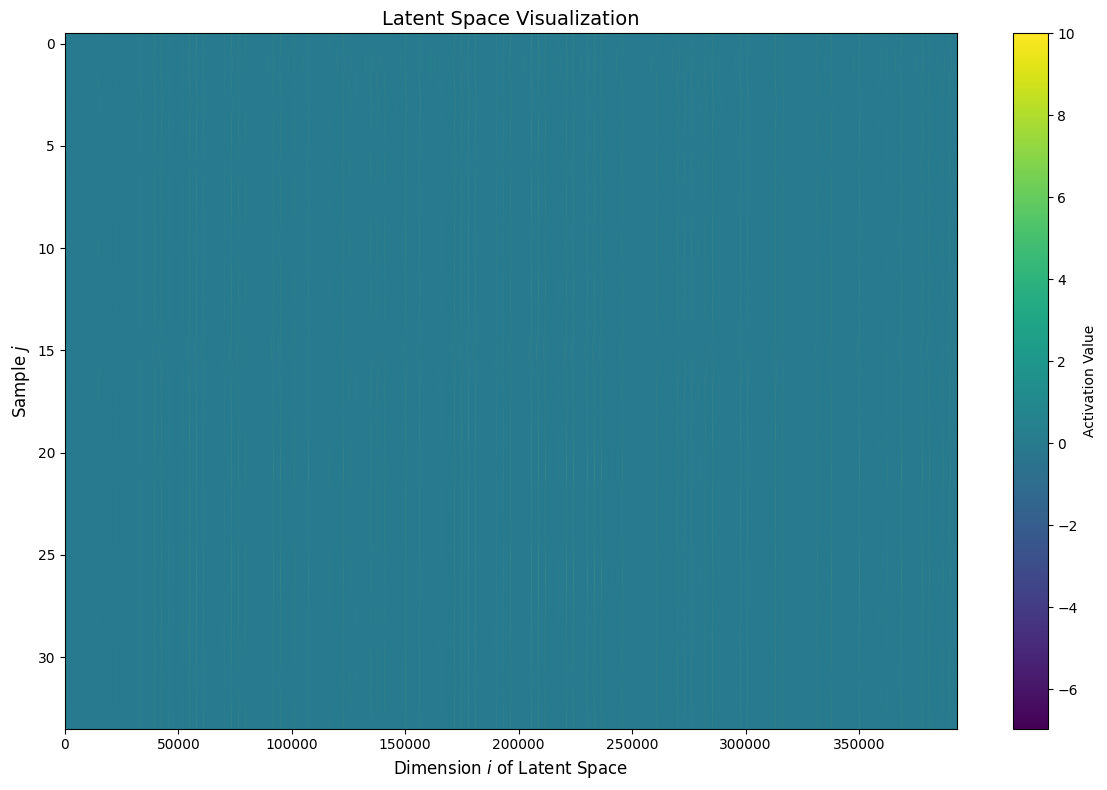

In [45]:


# Compute the latent representation from the test labels
latent = model.encoder(
    torch.tensor(test_labels, dtype=torch.float32, device=torch.device('cuda'))
).detach().cpu().numpy()

# Create a figure with a suitable size
plt.figure(figsize=(12, 8))

# Display the latent space matrix
im = plt.imshow(latent.reshape(latent.shape[0], -1), vmax=10, aspect='auto', cmap='viridis')

# Add labels, title, and a colorbar for reference
plt.xlabel(r'Dimension $i$ of Latent Space', fontsize=12)
plt.ylabel(r'Sample $j$', fontsize=12)
plt.title("Latent Space Visualization", fontsize=14)
plt.colorbar(im, label='Activation Value')
# Adjust layout to prevent clipping of labels and title
plt.tight_layout()
plt.show()
